### Use Case - Annual Water Usage in Baltimore

### Background

The Dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.
The values are in the units of liters per capita per day, and there are 79 observations.

### Objective

*Create a python script for the Use Case below, please upload the script after you finish.*
The Problem is to predict annual water usage.

### Instructions

* Load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).
* Create summary of the dataset, with python function.
* Create A line plot of a time series dataset, it will provide a lot of insight into the problem.
* Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.
* Create models using ARIMA
    * Split the dataset into train and test sets directly
    * The first 50% of the dataset will be held back to train the model.
    * The remaining 50% of the dataset will be iterated and test the model.
    * The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.
    * Use an ARIMA(0,1,0) on the raw data may be a good starting point.
    * When model trained, a one-step prediction made ang the prediction stored for later evaluation.
    * The actual observation from the test dataset woll be added to the training dataset for the next iteration.
    * The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.
* Calculate the RMSE using the helper function from the scikit-learn library, from dataset only
    * Those RMSE will show you on average, how much the error/the model was wrong/gap between predection and expected value per capita per day for each prediction made.

In [1]:
import math
import numpy as np
from scipy.stats import boxcox
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

#### Load Dataset

In [2]:
data = pd.read_csv('water.csv', parse_dates=[0], index_col=['Year'], header=0)

# Check if there is any missing values in the dataset
print('Nilai NaN atau Missing Value pada Dataset adalah %s '% (np.sum(data.isna())[0]))

Nilai NaN atau Missing Value pada Dataset adalah 0 


#### Summary of Dataset

In [3]:
data.describe()

,Water Usage
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 1885-01-01 to 1963-01-01
Data columns (total 1 columns):
Water Usage    79 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


In [5]:
data.shape

(79, 1)

#### Line and Density Plot for Insight

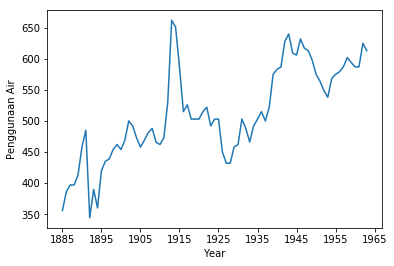

In [6]:
plt.plot(data)
plt.xlabel('Year')
plt.ylabel('Penggunaan Air')
plt.show()

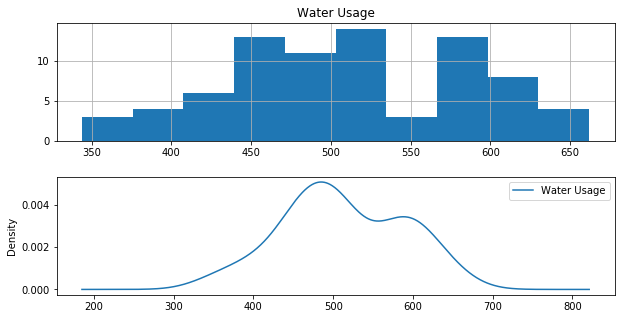

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(211)
data.hist(ax=plt.gca())
plt.subplot(212)
data.plot(kind='kde', ax=plt.gca())
plt.show()

### Create Model

#### Split the dataset into train and test sets directly

In [8]:
train_data, test_data = data[0:len(data)-10].values, data[len(data)-10:].values

### Stationary Test

In [9]:
adf_result = adfuller(np.concatenate(data.values.astype('float32')))
print('nilai p-value dari model adalah %.2f' % (adf_result[1]) )

nilai p-value dari model adalah 0.25


Following observation can be made from above p-value :
1- Given p-value of 0.25 seems like null hypothesis is accepted meaning that the data is not stationary and ARIMA model assumes data to be stationary, lets first make it stationary and then do ADF test

In [10]:
adf_data = data.values
adf_post_diff = adfuller(np.concatenate([adf_data[i] - adf_data[i-1] for i in range(1,len(adf_data))]))
print('nilai p-value setelah diferensiasi dan adf test adalah %.10f' % (adf_post_diff[1]))

nilai p-value setelah diferensiasi dan adf test adalah 0.0000000041


#### Analysis

Following observation can be made from above p-value :
1- Given p-value of 0.0000000041 seems like null hypothesis is rejected meaning that the data is stationary and we can model ARIMA on it, suggesting 1-level differencing is required.

### Find AR-MA parameters of ARIMA model using ACF and PACF plot

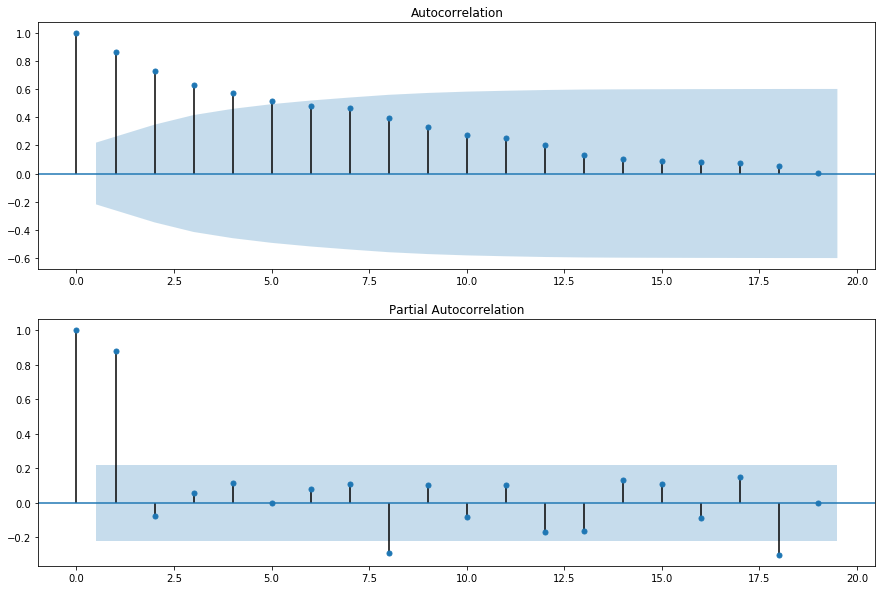

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(data, ax=plt.gca())
plt.subplot(212)
plot_pacf(data, ax=plt.gca())
plt.show()

**Following observations can be made from above plots :**

1. From ACF plot it can be observed that lag uptill 5 shows great correlation so will consider value of p=5 hence its an AR(5) process.
2. From PACF plot it can be observed that lag values uptill 1 so will consider value of q=1 hence its an MA(1) process.
3. Since, from the previous differencing part we found that d=1 makes the time series stationary, hence will take value of d=1.

### ARIMA Model

#### Persistence Model With Walk Forward Validation (Baseline RMSE)

In [12]:
def persistence_model(ps_tr_data, ps_test_data):
    
    history = [i for i in ps_tr_data]
    predictions = []
    
    for i in range(len(ps_test_data)):
        
        # Get predictions
        y_pred = history[-1]
        predictions.append(y_pred)
        
        #  Get actual
        history.append(ps_test_data[i])
        
        print('Prediksi: %.2f  Hasil Asli: %.2f' % (y_pred, ps_test_data[i]))
        
    print('Baseline RMSE : %.2f' % (math.sqrt(mean_squared_error(ps_test_data, predictions))))

# Persistence model
persistence_model(train_data, test_data)

Prediksi: 538.00  Hasil Asli: 568.00
Prediksi: 568.00  Hasil Asli: 575.00
Prediksi: 575.00  Hasil Asli: 579.00
Prediksi: 579.00  Hasil Asli: 587.00
Prediksi: 587.00  Hasil Asli: 602.00
Prediksi: 602.00  Hasil Asli: 594.00
Prediksi: 594.00  Hasil Asli: 587.00
Prediksi: 587.00  Hasil Asli: 587.00
Prediksi: 587.00  Hasil Asli: 625.00
Prediksi: 625.00  Hasil Asli: 613.00
Baseline RMSE : 17.19


### ARIMA (1,0,1)

In [13]:
def arima_obs(tr_ao, vl_ao, order):
    
    history = [i for i in tr_ao]
    predictions = []
    
    for i in range(len(vl_ao)):
        
        # get predictions
        fitted_model = ARIMA(history, order=order).fit(disp=0)
        y_pred = fitted_model.forecast()[0]
        predictions.append(y_pred)
        
        # append history values
        history.append(vl_ao[i])
        
        print('Prediksi: %.2f Hasil Asli: %.2f' % (y_pred, vl_ao[i]))
        
    print('\nRMSE: %.2f dengan model ARIMA%s' % (math.sqrt(mean_squared_error(vl_ao, predictions)), order))
    
    
    # RESIDUAL ANALYSIS
    print('\n\n Melihat hasil Plot - RESIDUAL ANALYSIS')
    rsd = pd.DataFrame([vl_ao[i] - predictions[i] for i in range(len(vl_ao))])
    
    # plot residuals
    plt.figure(figsize=(20,15))
    plt.subplot(511)
    rsd.hist(ax=plt.gca())
    plt.title('Histogram')
    plt.subplot(512)
    rsd.plot(kind='kde', ax=plt.gca())
    plt.title('Density Plot')
    plt.subplot(513)
    rsd.plot(kind='line', ax=plt.gca())
    plt.title('Line plot')
    plt.subplot(514)
    plot_acf(rsd, ax=plt.gca())
    plt.subplot(515)
    plot_pacf(rsd, ax=plt.gca())
    plt.tight_layout()
    plt.show()

Prediksi: 531.80 Hasil Asli: 568.00
Prediksi: 563.17 Hasil Asli: 575.00
Prediksi: 566.98 Hasil Asli: 579.00
Prediksi: 570.88 Hasil Asli: 587.00
Prediksi: 578.89 Hasil Asli: 602.00
Prediksi: 593.74 Hasil Asli: 594.00
Prediksi: 584.14 Hasil Asli: 587.00
Prediksi: 578.27 Hasil Asli: 587.00
Prediksi: 579.16 Hasil Asli: 625.00
Prediksi: 618.56 Hasil Asli: 613.00

RMSE: 21.46 dengan model ARIMA(1, 0, 1)


 Melihat hasil Plot - RESIDUAL ANALYSIS


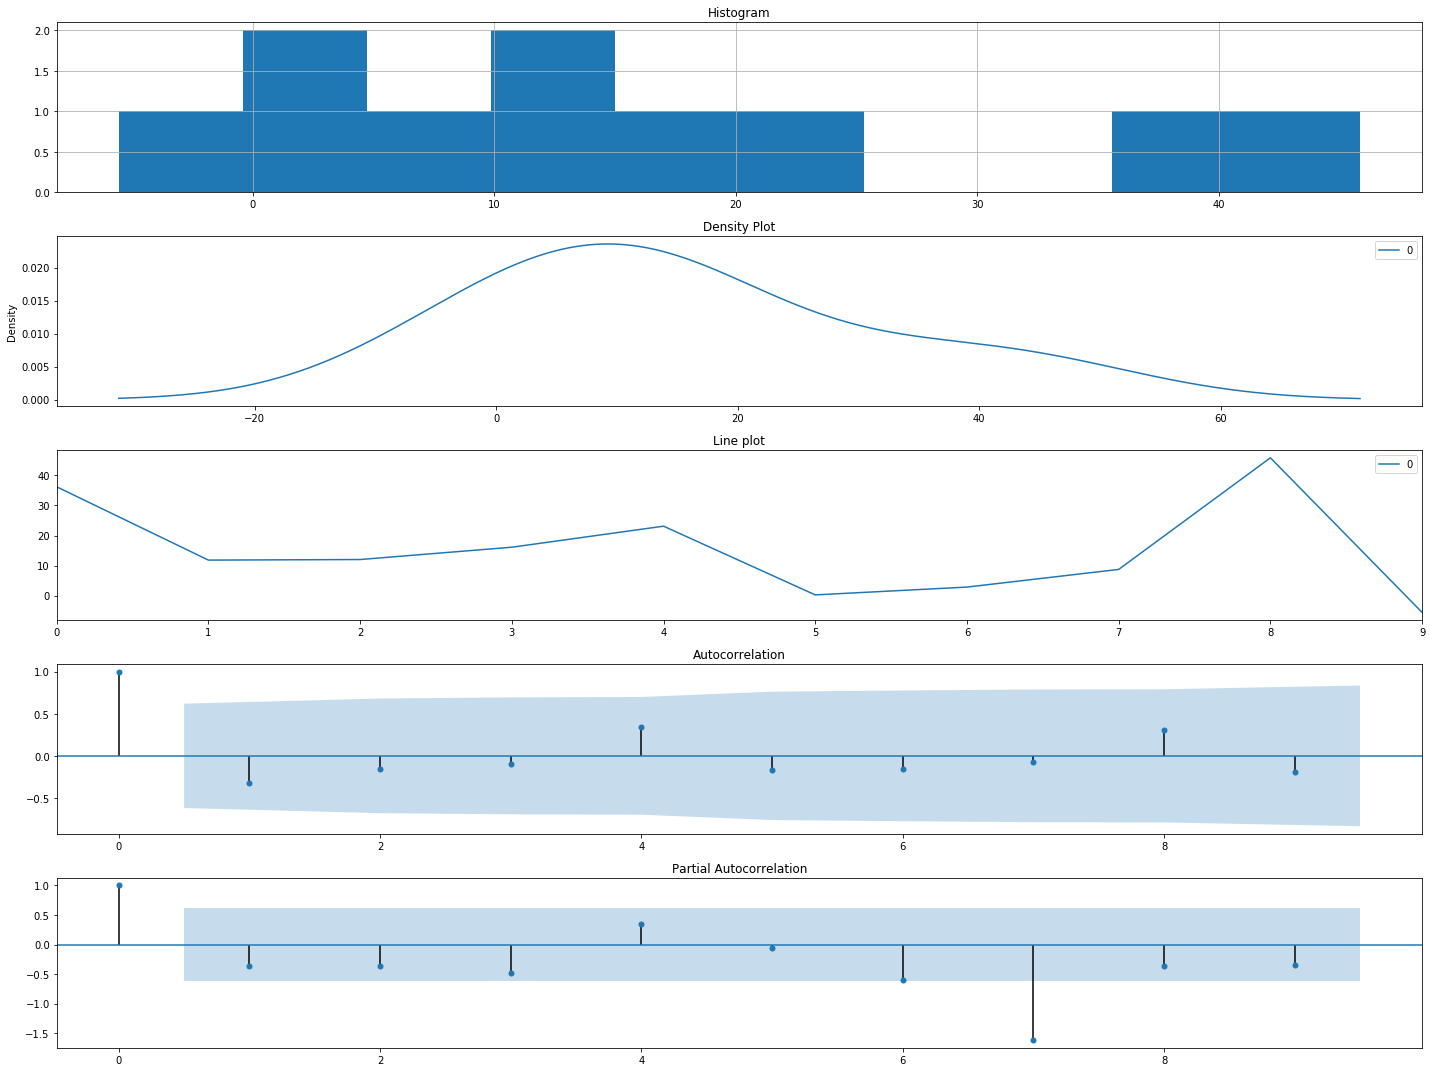

In [14]:
arima_obs(train_data, test_data, (1,0,1))

Following observation can be made from the above ARIMA(1,0,1)
1. RMSE value of 21.46 seems like bad performance as compared to persistence model
2. ACF and PACF show that majority of the correlation is captured by the model.
3. Observing histogram and density plots suggest applying power transform on the data to better expose the signal by removing the noise, before modelling ARIMA on the data.
4. Lets apply GRID search on ARIMA with power transformed dataset with walk-forward validation model.

### Grid Search Model ARIMA untuk Estimasi Model Terbaik

In [15]:
def inverse_boxcox(x_val, lm_val):
    
    if lm_val == 0:
        return np.exp(x_val)
    
    return np.exp(np.log(lm_val * x_val + 1) / lm_val)

In [16]:
def evaluate_arima_model_power_transform(train, test, order):
    
    eval_history = [i for i in train]
    
    eval_predictions = []
    
    for i in range(len(test)):
        
        # Box transform
        train_hist, lmb = boxcox(eval_history)
        
        if lmb < -5:
            train_hist, lmb = eval_history, 1
        
        # Fit model and predict
        model = ARIMA(train_hist, order=order)
        eval_predictions.append(inverse_boxcox(model.fit(disp=0).forecast()[0], lmb))
        
        # Get y_true
        eval_history.append(test[i])
    
    # Evaluate performance
    rmse = np.sqrt(mean_squared_error(test, eval_predictions))
    return rmse

In [19]:
def grid_ARIMA_power_transform(p_values, d_values, q_values):
    
    
    best_rmse, best_cfg = float('inf'), None
    
    
    for i in p_values:
        for j in d_values:
            for k in q_values:                    
                
                try:
                    
                    grid_rmse = evaluate_arima_model_power_transform(train_data, test_data, (i,j,k))
                    
                    if grid_rmse < best_rmse:
                        best_rmse, best_cfg = grid_rmse, (i,j,k)
                        
                    print('Nilai RMSE: %.2f ARIMA dengan order : p:%s, d:%s and q:%s'% (grid_rmse, i,j,k))
                
                except:
                    continue
                

    print('\nNilai RMSE Terbaik: %.2f with ARIMA(p:%s, d:%s, q:%s)' % (best_rmse, best_cfg[0], best_cfg[1], best_cfg[2]))

In [20]:
# Define parameters p, d and q
p = np.arange(0, 5)
d = np.arange(0, 4)
q = np.arange(0, 3)

grid_ARIMA_power_transform(p,d,q)

Got RMSE: 89.11 ARIMA CFG : p:0, d:0 and q:0
Got RMSE: 54.25 ARIMA CFG : p:0, d:0 and q:1
Got RMSE: 39.73 ARIMA CFG : p:0, d:0 and q:2
Got RMSE: 16.14 ARIMA CFG : p:0, d:1 and q:0
Got RMSE: 16.23 ARIMA CFG : p:0, d:1 and q:1
Got RMSE: 15.23 ARIMA CFG : p:0, d:1 and q:2
Got RMSE: 26.38 ARIMA CFG : p:0, d:2 and q:0
Got RMSE: 17.87 ARIMA CFG : p:0, d:2 and q:1
Got RMSE: 18.00 ARIMA CFG : p:0, d:2 and q:2
Got RMSE: 21.39 ARIMA CFG : p:1, d:0 and q:0
Got RMSE: 21.70 ARIMA CFG : p:1, d:0 and q:1
Got RMSE: 21.78 ARIMA CFG : p:1, d:0 and q:2
Got RMSE: 16.21 ARIMA CFG : p:1, d:1 and q:0
Got RMSE: 23.67 ARIMA CFG : p:1, d:2 and q:0
Got RMSE: 17.98 ARIMA CFG : p:1, d:2 and q:1
Got RMSE: 16.32 ARIMA CFG : p:1, d:2 and q:2
Got RMSE: 21.73 ARIMA CFG : p:2, d:0 and q:0
Got RMSE: 21.70 ARIMA CFG : p:2, d:0 and q:1
Got RMSE: 15.81 ARIMA CFG : p:2, d:1 and q:0
Got RMSE: 22.48 ARIMA CFG : p:2, d:2 and q:0
Got RMSE: 21.54 ARIMA CFG : p:3, d:0 and q:0
Got RMSE: 20.39 ARIMA CFG : p:3, d:0 and q:1
Got RMSE: 